# Import & Enrich Data
This block downloads corporate data from [the Corporate Number Publication Site](https://www.houjin-bangou.nta.go.jp/en/) in Japan and labels category data to improve data quality. This block creates the enriched corporate dataset `df`.

In [1]:
import os
import cnparser as cn

file_name = "./00_zenkoku_all_20240430.csv"
raw = cn.read_csv(file_name) if os.path.exists(file_name) else cn.load()
raw.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5467443 entries, 0 to 5467442
Data columns (total 30 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   sequence_number             5467443 non-null  object
 1   corporate_number            5467443 non-null  object
 2   process                     5467443 non-null  object
 3   correct                     5467443 non-null  object
 4   update_date                 5467443 non-null  object
 5   change_date                 5467443 non-null  object
 6   name                        5467443 non-null  object
 7   name_image_id               63662 non-null    object
 8   kind                        5467443 non-null  object
 9   prefecture_name             5460196 non-null  object
 10  city_name                   5460196 non-null  object
 11  street_number               5459446 non-null  object
 12  address_image_id            53092 non-null    object
 13  prefecture_c

In [27]:
# Convert the values in the 'kind' column to descriptive strings
kind_mapping = {'101': 'National Agency', '201': 'Local Government', '301': 'K.K.', '302': 'Y.K.', '303': 'GP', '304': 'LLP.', '305': 'LLC.', '399': 'Other Corp.', '401': 'Foreign Corp.', '499': 'Other'}
raw['std_legal_entity'] = raw['kind'].map(kind_mapping)
# Convert the format of the postal code and add a new column
raw['std_post_code'] = raw['post_code'].astype(str).apply(lambda x: f"{x[:3]}-{x[3:]}")

In [28]:
# Select required columns
cols = ['corporate_number', 'name', 'furigana', 'en_name', 'std_legal_entity', 'std_post_code', 'prefecture_name', 'city_name', 'street_number', 'en_prefecture_name', 'en_city_name', 'en_address_outside']
df = raw[cols]

# basic statistic

In [29]:
# Calculate basic statistics
desc = df.describe(include='object')
# Calculate the count and rate of missing values and add them to desc
missing_cnt = df.isnull().sum()
missing_rate = missing_cnt / len(df) * 100
desc.loc['Missing Cnt'] = missing_cnt
desc.loc['Missing Rate'] = missing_rate.map("{:.2f}%".format)
# Display the results
desc.head(10)

,corporate_number,name,furigana,en_name,std_legal_entity,std_post_code,prefecture_name,city_name,street_number,en_prefecture_name,en_city_name,en_address_outside
count,5467443,5467443,2926632,12892,5467443,5467443,5460196,5460196,5459446,12572,12572,29
unique,5467443,3910104,1694503,12819,10,108207,47,1951,4185359,47,8511,29
top,1000012160153,八幡神社,ライズ,Amakusa City,K.K.,104-0061,東京都,港区,丸の内３丁目１番１号東京共同会計事務所内,Tokyo,"1-1-1,Daiku, Kita ku,Okayama shi","1232 Waimanu street, suiteA-2 Honolulu, Hawaii 96814, U.S.A."
freq,1,4733,1096,6,2708099,25452,1261346,146609,3938,2431,285,1
Missing Cnt,0,0,2540811,5454551,0,0,7247,7247,7997,5454871,5454871,5467414
Missing Rate,0.00%,0.00%,46.47%,99.76%,0.00%,0.00%,0.13%,0.13%,0.15%,99.77%,99.77%,100.00%


In [31]:
df.sample(5)

,corporate_number,name,furigana,en_name,std_legal_entity,std_post_code,prefecture_name,city_name,street_number,en_prefecture_name,en_city_name,en_address_outside
5387950,9340002009162,有限会社マル平,NaN,NaN,Y.K.,891-1107,鹿児島県,鹿児島市,有屋田町６０３番地５,NaN,NaN,NaN
3724464,4130001063707,日本サームリーン株式会社,ニホンサームリーン,NaN,K.K.,616-8186,京都府,京都市右京区,太秦堀池町１６番地５８,NaN,NaN,NaN
2710655,6120002048020,有限会社ピアノロウグ,ピアノロウグ,NaN,Y.K.,251-0032,神奈川県,藤沢市,片瀬４丁目１８番２４号片瀬パークハウス２０５,NaN,NaN,NaN
1267062,1010601038841,株式会社ライフプランサービス,NaN,NaN,K.K.,135-0002,東京都,江東区,住吉２丁目３番５号鷲巣ビル３Ｆ,NaN,NaN,NaN
4001442,5120001147542,株式会社オーケーベビー,NaN,NaN,K.K.,572-0051,大阪府,寝屋川市,高柳５丁目６番６号,NaN,NaN,NaN


### Legacy analysis: Below codes does not work


In [6]:
# Count the unique records for each 'kind'
kind_counts = df['kind'].value_counts()
# Display the results
print(kind_counts)

kind
K.K.                2708099
Y.K.                1677946
Other Corp.          561489
LLC.                 363487
LLP.                  93679
GP                    19234
Other                 18652
Foreign Corp.         16599
Local Government       7411
National Agency         847
Name: count, dtype: int64


### Number of companies with enName

In [38]:
# Create a new dataframe by selecting 'name', 'enName', and 'kind' columns from the original dataframe
filtered_df = df[['name', 'enName', 'kind']]
# Group by 'kind' and count non-null and null values in 'enName' column, filling missing data with 0
counts = filtered_df.groupby('kind')['enName'].apply(lambda x: x.notna().value_counts()).unstack(fill_value=0)
# Rename columns for clarity
counts.rename(columns={False: 'CNT_NaN', True: 'CNT_Filled'}, inplace=True)
# Calculate the total count for each 'kind'
counts['Total'] = counts['CNT_NaN'] + counts['CNT_Filled']
counts['Fill_Rate'] = round(counts['CNT_Filled'] / counts['Total'] * 100)
# Sort the dataframe by 'Total' in descending order
counts = counts.sort_values(by='Total', ascending=False)
counts.head(10)

,CNT_NaN,CNT_Filled,Total,Fill_Rate
kind,,,,
K.K.,2704163,3936,2708099,0.0
Y.K.,1677791,155,1677946,0.0
Other Corp.,561247,242,561489,0.0
LLC.,362757,730,363487,0.0
LLP.,93676,3,93679,0.0
GP,19234,0,19234,0.0
Other,18637,15,18652,0.0
Foreign Corp.,16569,30,16599,0.0
Local Government,477,6934,7411,94.0


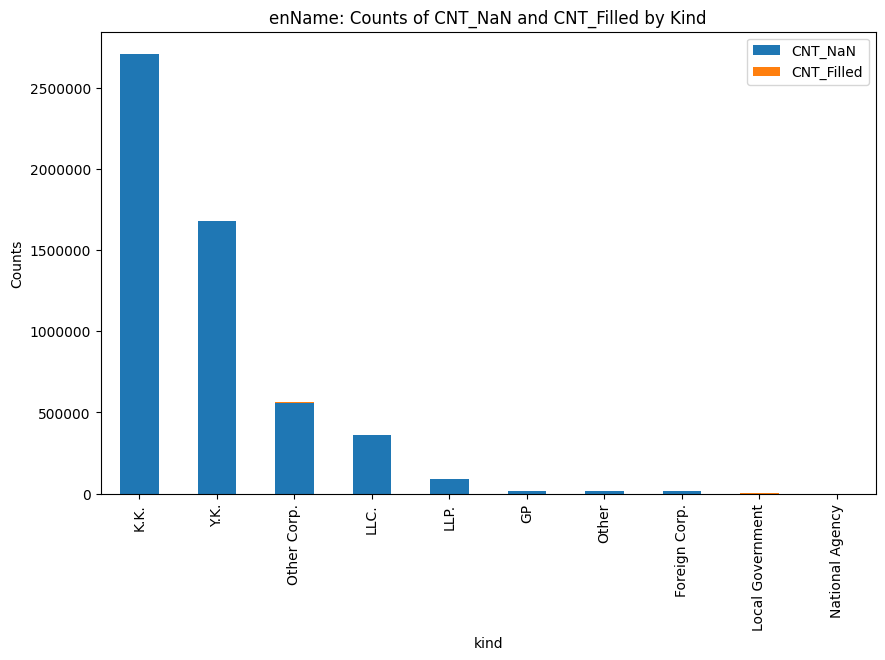

In [26]:
import matplotlib.pyplot as plt

# Create a stacked bar chart
counts[['CNT_NaN', 'CNT_Filled']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('enName: Counts of CNT_NaN and CNT_Filled by Kind')
# Display counts as actual numbers instead of scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('kind')
plt.ylabel('Counts')
plt.legend(['CNT_NaN', 'CNT_Filled'])
plt.show()


### Number of companies with furigana

In [36]:
# Create a new dataframe by selecting 'name', 'furigana', and 'kind' columns from the original dataframe
filtered_df = df[['name', 'furigana', 'kind']]
# Group by 'kind' and count non-null and null values in 'enName' column, filling missing data with 0
counts = filtered_df.groupby('kind')['furigana'].apply(lambda x: x.notna().value_counts()).unstack(fill_value=0)
# Rename columns for clarity
counts.rename(columns={False: 'CNT_NaN', True: 'CNT_Filled'}, inplace=True)
# Calculate the total count for each 'kind'
counts['Total'] = counts['CNT_NaN'] + counts['CNT_Filled']
counts['Fill_Rate'] = round(counts['CNT_Filled'] / counts['Total'] * 100)
# Sort the dataframe by 'Total' in descending order
counts = counts.sort_values(by='Total', ascending=False)
counts.head(10)

,CNT_NaN,CNT_Filled,Total,Fill_Rate
kind,,,,
K.K.,889447,1818652,2708099,67.0
Y.K.,1219113,458833,1677946,27.0
Other Corp.,229889,331600,561489,59.0
LLC.,98208,265279,363487,73.0
LLP.,86749,6930,93679,7.0
GP,17174,2060,19234,11.0
Other,97,18555,18652,99.0
Foreign Corp.,134,16465,16599,99.0
Local Government,0,7411,7411,100.0


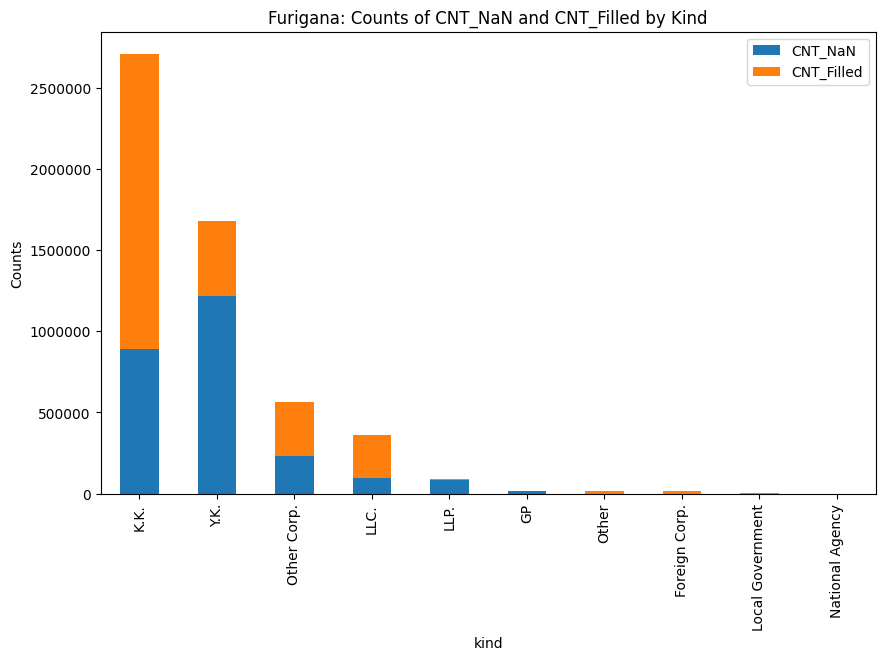

In [24]:
import matplotlib.pyplot as plt

# Create a stacked bar chart
counts[['CNT_NaN', 'CNT_Filled']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Furigana: Counts of CNT_NaN and CNT_Filled by Kind')
# Display counts as actual numbers instead of scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('kind')
plt.ylabel('Counts')
plt.legend(['CNT_NaN', 'CNT_Filled'])
plt.show()

### Number of streetNumber

In [37]:
# Create a new dataframe by selecting 'name', 'streetNumber', and 'kind' columns from the original dataframe
filtered_df = df[['name', 'streetNumber', 'kind']]
# Group by 'kind' and count non-null and null values in 'enName' column, filling missing data with 0
counts = filtered_df.groupby('kind')['streetNumber'].apply(lambda x: x.notna().value_counts()).unstack(fill_value=0)
# Rename columns for clarity
counts.rename(columns={False: 'CNT_NaN', True: 'CNT_Filled'}, inplace=True)
# Calculate the total count for each 'kind'
counts['Total'] = counts['CNT_NaN'] + counts['CNT_Filled']
counts['Fill_Rate'] = round(counts['CNT_Filled'] / counts['Total'] * 100)
# Sort the dataframe by 'Total' in descending order
counts = counts.sort_values(by='Total', ascending=False)
counts.head(10)

,CNT_NaN,CNT_Filled,Total,Fill_Rate
kind,,,,
K.K.,0,2708099,2708099,100.0
Y.K.,6,1677940,1677946,100.0
Other Corp.,660,560829,561489,100.0
LLC.,2,363485,363487,100.0
LLP.,70,93609,93679,100.0
GP,12,19222,19234,100.0
Other,1,18651,18652,100.0
Foreign Corp.,7246,9353,16599,56.0
Local Government,0,7411,7411,100.0


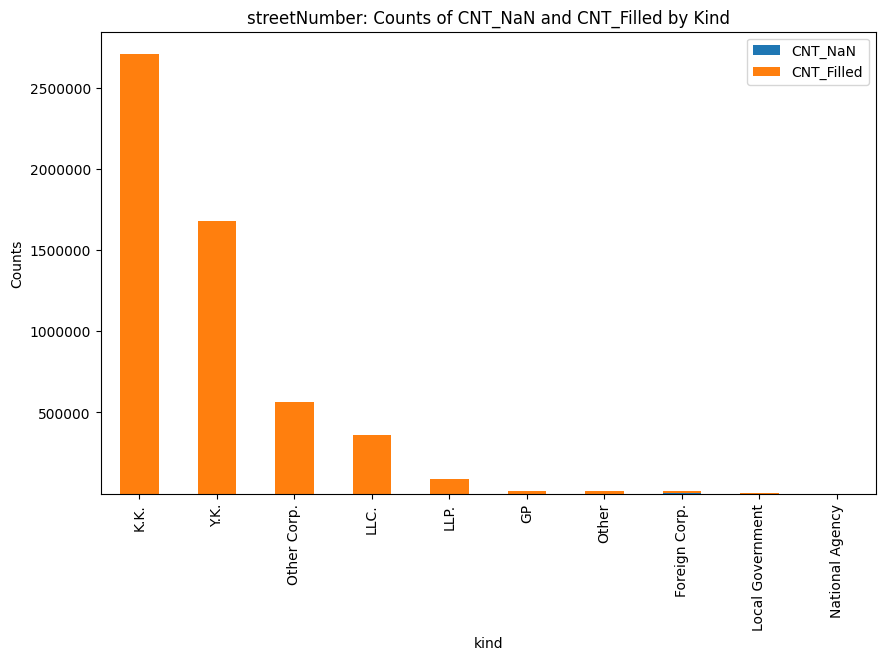

In [22]:
import matplotlib.pyplot as plt

# Create a stacked bar chart
counts[['CNT_NaN', 'CNT_Filled']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('streetNumber: Counts of CNT_NaN and CNT_Filled by Kind')
# Display counts as actual numbers instead of scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('kind')
plt.ylabel('Counts')
plt.legend(['CNT_NaN', 'CNT_Filled'])
plt.show()

### Number of enCityName

In [39]:
# Create a new dataframe by selecting 'name', 'enCityName', and 'kind' columns from the original dataframe
filtered_df = df[['name', 'enCityName', 'kind']]
# Group by 'kind' and count non-null and null values in 'enName' column, filling missing data with 0
counts = filtered_df.groupby('kind')['enCityName'].apply(lambda x: x.notna().value_counts()).unstack(fill_value=0)
# Rename columns for clarity
counts.rename(columns={False: 'CNT_NaN', True: 'CNT_Filled'}, inplace=True)
# Calculate the total count for each 'kind'
counts['Total'] = counts['CNT_NaN'] + counts['CNT_Filled']
counts['Fill_Rate'] = round(counts['CNT_Filled'] / counts['Total'] * 100)
# Sort the dataframe by 'Total' in descending order
counts = counts.sort_values(by='Total', ascending=False)
counts.head(10)

,CNT_NaN,CNT_Filled,Total,Fill_Rate
kind,,,,
K.K.,2704405,3694,2708099,0.0
Y.K.,1677793,153,1677946,0.0
Other Corp.,561262,227,561489,0.0
LLC.,362802,685,363487,0.0
LLP.,93676,3,93679,0.0
GP,19234,0,19234,0.0
Other,18636,16,18652,0.0
Foreign Corp.,16570,29,16599,0.0
Local Government,491,6920,7411,93.0


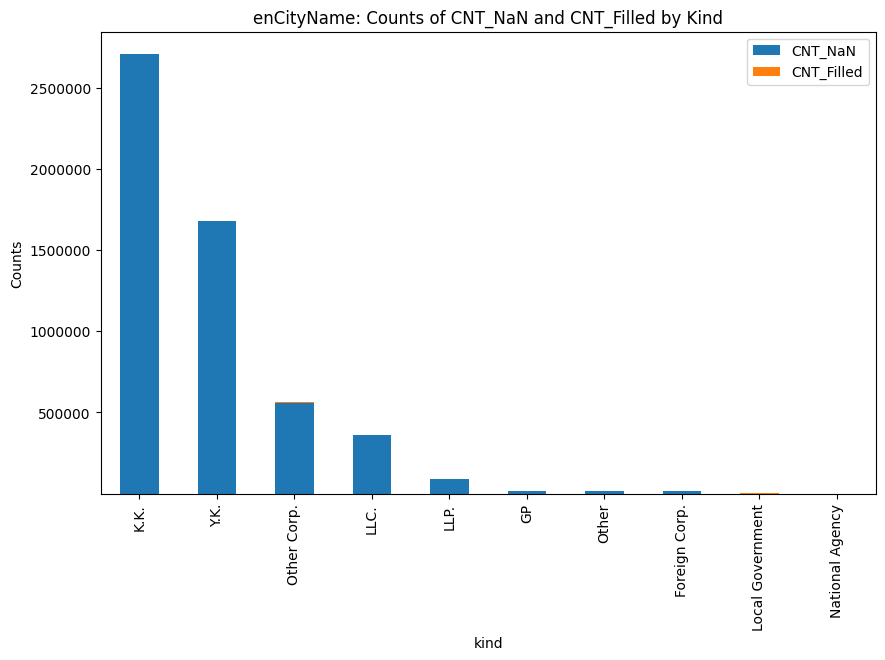

In [20]:
import matplotlib.pyplot as plt

# Create a stacked bar chart
counts[['CNT_NaN', 'CNT_Filled']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('enCityName: Counts of CNT_NaN and CNT_Filled by Kind')
# Display counts as actual numbers instead of scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('kind')
plt.ylabel('Counts')
plt.legend(['CNT_NaN', 'CNT_Filled'])
plt.show()